<h1><center> ODABIR ZNAČAJKI </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

1. [Učitavanje i priprema značajki](#priprema)
2. [Izbacivanje značajki na temelju točnosti modela](#grupe)
    1. [Značajke iz <i>.bytes</i> datoteka](#bytes)
    2. [Značajke iz <i>.asm</i> datoteka](#asm)
    3. [Odabrane podgrupe značajki](#podgrupe)
3. [Odabir značajki uz pomoć prediktivnog modela](#odabir)

In [53]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.utils import class_weight

from functions.model_helper import *
from functions.fs_helper import *
from functions.univariate import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Vodeći se informacijama prikupljenim kroz detaljnu [eksploratornu analizu](https://github.com/tomarga/Machine-Burning/blob/master/src/%5Bproject%20proposal%5D%20microsoft%20malware%20classification.ipynb) podataka, možemo odabrati podskup _najvažnijih_ značajki koji ćemo koristiti u treniranju modela. Pritom naravno želimo uz minimalni broj značajki dobiti što ispravniji model.

***


# 1. Učitavanje i priprema značajki <a name = priprema />

U sljedećih nekoliko linija učitat ćemo značajke koje smo rudarili na način prikazan u [Feature extraction](https://github.com/tomarga/Machine-Burning/blob/master/src/Feature%20extraction.ipynb) bilježnici. <br>

Vidimo da orginalnih značajki ima $1693$. Kako ne bi koristili sve $1693$ značajke pri izradi modela i tako ga <i>overfittali</i>, u ovoj bilježnici nastojat ćemo odabrati manji skup značajki koje će dovoljno dobro opisivati tražene klase <i>malware</i>a. 

In [2]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")
features_train.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [3]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Columns: 1695 entries, Id to unableto
dtypes: float64(303), int64(1391), object(1)
memory usage: 140.5+ MB


In [4]:
# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)
features_test.head()

,Id,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,byte_1G_08,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,ITSUPtCmh7WdJcsYDwQ5,26006,1711,2279,1467,1691,1168,1048,1126,2595,...,0,0,7,0,0,0,0,0,0,0
1,Ig2DB5tSiEy1cJvV0zdw,14753,1685,1742,1235,1476,1135,1010,1038,1449,...,0,0,6,0,0,0,0,0,0,0
2,Jmo6eIhLZ4t9r8QsxEg5,13279,1945,1783,1421,1496,1351,1130,1007,1546,...,0,0,12,0,0,0,0,0,0,0
3,JtPFl4ewgdD78OzCMa3o,7558,944,804,883,814,1072,616,723,876,...,0,0,0,0,0,0,0,0,0,0
4,K3ZtByPHGSFYNljDUEXp,8504,4195,3019,3099,3101,3200,3161,3183,3070,...,0,0,0,0,0,0,0,0,0,0


In [5]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10873 entries, 0 to 872
Columns: 1694 entries, Id to unableto
dtypes: float64(303), int64(1390), object(1)
memory usage: 140.6+ MB


### <code>NaN</code> vrijednosti

Kako bi uspješno mogli iskoristiti neke od metoda za odabir najvažnijih značajki, moramo garantirati da su svi stupci u tablici značajki jednake duljine. U tu svrhu, prije nego što krenemo smanjivati dimenzionalnost prostora značajki, gledamo postoje li podaci s <code>NaN</code> vrijednostima.

In [6]:
def find_features_with_NaN ( features ) :
    features_with_null_values = []
    
    for i in range(features.shape[1]) :
        if features.count()[i] < features.shape[0] :
            features_with_null_values.append( features_train.count().index[i] )
    
    return features_with_null_values

In [7]:
# find features with NaN values on trainset
train_features_with_NaN = find_features_with_NaN( features_train )
print( train_features_with_NaN )

['.text', '.data', '.bss', '.rdata', '.edata', '.idata', '.rsrc', '.tls', '.reloc', 'Num_Sections', 'Unknown_Sections', 'Unknown_Sections_lines', '.text_por', '.data_por', '.bss_por', '.rdata_por', '.edata_por', '.idata_por', '.rsrc_por', '.tls_por', '.reloc_por', 'known_Sections_por', 'Unknown_Sections_por', 'Unknown_Sections_lines_por', 'db_por', 'dd_por', 'dw_por', 'dc_por', 'db0_por', 'dbN0_por', 'dd_text', 'db_text', 'dd_rdata', 'db3_rdata', 'db3_data', 'db3_all', 'dd4', 'dd5', 'dd6', 'dd4_all', 'dd5_all', 'dd6_all', 'db3_idata', 'db3_NdNt', 'dd4_NdNt', 'dd5_NdNt', 'dd6_NdNt', 'db3_all_zero']


In [8]:
# find features with NaN values on testset
test_features_with_NaN = find_features_with_NaN( features_test )
print( test_features_with_NaN )

['asm_regs_esp', '.text', '.data', '.bss', '.rdata', '.edata', '.idata', '.rsrc', '.tls', '.reloc', 'Num_Sections', 'Unknown_Sections', 'Unknown_Sections_lines', '.text_por', '.data_por', '.bss_por', '.rdata_por', '.edata_por', '.idata_por', '.rsrc_por', '.tls_por', '.reloc_por', 'known_Sections_por', 'Unknown_Sections_por', 'Unknown_Sections_lines_por', 'db_por', 'dd_por', 'dw_por', 'dc_por', 'db0_por', 'dbN0_por', 'dd_text', 'db_text', 'dd_rdata', 'db3_rdata', 'db3_data', 'db3_all', 'dd4', 'dd5', 'dd6', 'dd4_all', 'dd5_all', 'dd6_all', 'db3_idata', 'db3_NdNt', 'dd4_NdNt', 'dd5_NdNt', 'dd6_NdNt']


Vidimo da se i u slučaju _train_ i _test_ skupa podataka radi o značajkama iz skupine **sekcije** (SEC) i **data define** (DD). Po analizi iz [Feature extraction](https://github.com/tomarga/Machine-Burning/blob/master/src/Feature%20extraction.ipynb) bilježnice, znamo da se sve ove značajke odnose na omjer broja određenih linija (SEC) ili omjer korištenja određenih instrukcija (DD) u <i>.asm</i> datoteci. <code>NaN</code>  vrijednosti su stoga rezultat dijeljenja $\frac{0}{0}$. Informacija da ne postoji određenih linija ili instrukcija u nekoj sekciji <i>.asm</i> datoteke nam nije beznačajna, tako da na mjesta <code>NaN</code> vrijednosti postavljamo $0$.

In [9]:
# NaN -> 0
features_train_with_filled_NaN_without_id = features_train.fillna(0, inplace = False)
features_test_with_filled_NaN_without_id = features_train.fillna(0, inplace = False)

Prisjetimo se kako su nam značajke količinski raspoređene po podgrupama koje promatramo.

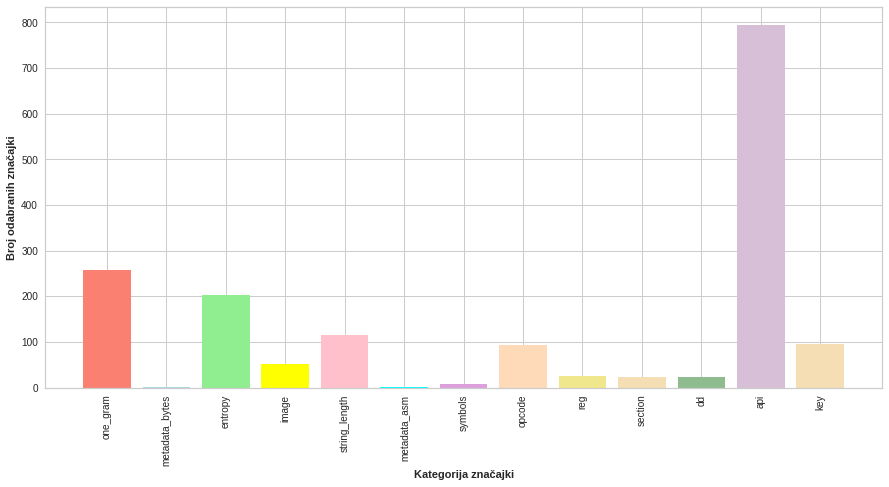

In [10]:
features_type_quantity(features_train_with_filled_NaN_without_id, features_train)

<br>

# 2. Izbacivanje značajki na temelju točnosti modela <a name = grupe> </a>

U provedenoj eksporatornoj analizi osvrnuli smo se na svaku kategoriju značajki zasebno. Iz analize se dalo naslutiti kako kategorije uvelike variraju po značajnosti. Zato nastavljamo analizu po kategorijama te kao prvi korak selekcije provodimo eliminaciju beznačajnih kategorija. Značajnost svake kategorije određujemo prema rezultatima jednostavnog modela za klasifikaciju koji se trenira na značajkama isključivo te kateogrije.

Prvo učitavamo potrebne strukture podataka.

In [11]:
#remember default python style
#IPython_default = plt.rcParams.copy()

In [4]:
# dictionary for saving malware names
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

# define seed
seed = 42

In [5]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)

# malware ids
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")

# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

# features with filled NaN with zero
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

##  2.1 Značajke iz <i>.bytes</i> datoteka <a name = bytes> </a>

### unigrami

Kao što smo najavili, radimo jednostavni model za klasifikaciju <i>malware</i>a, korišteći samo unigram značajke te pomoću raznih metrika točnosti pokušati predvidjeti njihovu značajnost u konačnom modelu.

In [14]:
# extract
one_gram_features = features_train_with_filled_NaN_without_id.iloc[:,:256]
one_gram_features_test = features_test_with_filled_NaN_without_id.iloc[:,:256]

In [15]:
data = one_gram_features
data_test = one_gram_features_test
labels = malware_classes_train.values.ravel()

In [16]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [18]:
# xgboost with default parameters
basic_model_unigram = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)

Load or make XGBClassifier? make
Ime za XGBClassifier? unigram
[0]	validation_0-merror:0.02657	validation_0-mlogloss:1.09758	validation_1-merror:0.04462	validation_1-mlogloss:1.12106
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.01725	validation_0-mlogloss:0.76516	validation_1-merror:0.03266	validation_1-mlogloss:0.79814
[2]	validation_0-merror:0.01242	validation_0-mlogloss:0.55830	validation_1-merror:0.02990	validation_1-mlogloss:0.59818
[3]	validation_0-merror:0.01047	validation_0-mlogloss:0.41526	validation_1-merror:0.02576	validation_1-mlogloss:0.46016
[4]	validation_0-merror:0.00886	validation_0-mlogloss:0.31339	validation_1-merror:0.02392	validation_1-mlogloss:0.36225
[5]	validation_0-merror:0.00736	validation_0-mlogloss:0.23835	validation_1-merror:0.02162	validation_1-mlogloss:0.28929
[6]	validation_0-merror:0.00679	validation_0-mlogl

[66]	validation_0-merror:0.00000	validation_0-mlogloss:0.00116	validation_1-merror:0.01334	validation_1-mlogloss:0.05492
[67]	validation_0-merror:0.00000	validation_0-mlogloss:0.00115	validation_1-merror:0.01334	validation_1-mlogloss:0.05491
Stopping. Best iteration:
[47]	validation_0-merror:0.00000	validation_0-mlogloss:0.00161	validation_1-merror:0.01334	validation_1-mlogloss:0.05449

XGBClassifier je spremljen u: ../dataset/basic_model/model_xgb_unigram.sav


In [19]:
model = basic_model_unigram

In [20]:
# load ~> trebam napraviti da se može loadati iz funkcije isti
# model = basic_model_xgb = pickle.load(open('data/model_xgb_one_gram.sav', 'rb'))

In [21]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.054491
1,accuracy_test,0.986661
2,F1_test,0.986648
3,precision_test,0.986823
4,auc_test_ovr,0.999673
5,auc_test_ovo,0.999496
6,r2_test,0.945554


Ovdje smo ispisali različite metrike uspješnosti našega jednostavnog modela. Ono što možemo primjetiti da su rezultati svih metrika vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

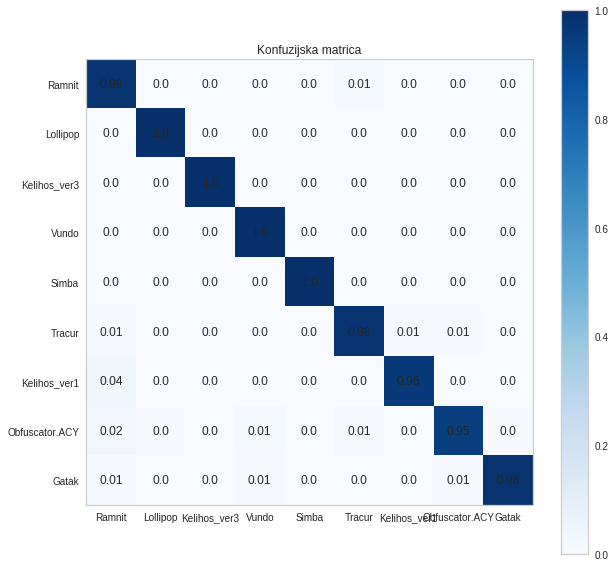

In [22]:
# plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

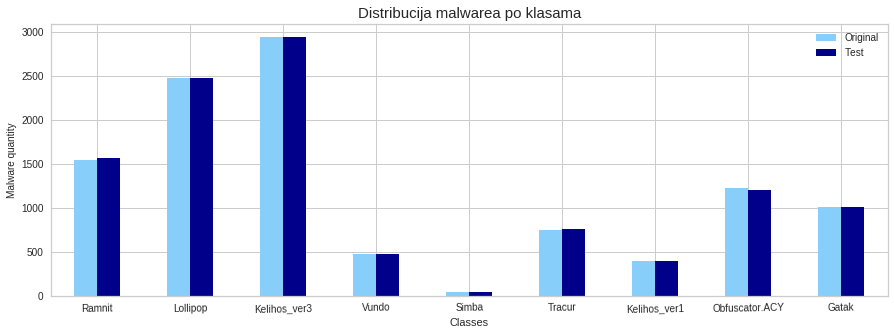

In [23]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Gornji prikaz je usporedba distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije). Minimalna razlika u visini 'sparenih' stupaca je pokazatelj dobre grupiranosti podataka. Svejedno, nemamo garanciju da su test podaci stvarno iste strukture kao i train podaci, kao što naši rezultati nalažu. Zato dodatno provjeravamo rezultat <i>submitanjem</i> na Kaggle. 

In [129]:
# make a submisson file
#name = input("Ime za submisson file? ")
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? unigram


<code> kaggle score: 0.05030 </code>

Uistinu, model se pokazao jako dobrim i na nepoznatim podacima.<br> 
Ovakav rezultat nas ne čudi jer se ova kategorija značajki pokazala kvalitetnom već pri prvoj analizi u [projektnom prijedlogu](https://github.com/tomarga/Machine-Burning/blob/master/src/%5Bproject%20proposal%5D%20microsoft%20malware%20classification.ipynb).

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

Slijedi analogna analiza svih ostalih skupina značajki.

<br>

### metadata

In [4]:
# extract
metadata_bytes_features = features_train_with_filled_NaN_without_id.iloc[:,256:258]
metadata_bytes_features_test = features_test_with_filled_NaN_without_id.iloc[:,256:258]

In [5]:
data = metadata_bytes_features
data_test = metadata_bytes_features_test
labels = malware_classes_train.values.ravel()

In [6]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [8]:
# xgboost with default parameters
basic_model_metadata_bytes = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_metadata_bytes

Load or make XGBClassifier? make
Ime za XGBClassifier? metadata_bytes
[0]	validation_0-merror:0.16853	validation_0-mlogloss:1.34315	validation_1-merror:0.19871	validation_1-mlogloss:1.36351
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.16070	validation_0-mlogloss:1.06242	validation_1-merror:0.18583	validation_1-mlogloss:1.09276
[2]	validation_0-merror:0.15127	validation_0-mlogloss:0.88412	validation_1-merror:0.17433	validation_1-mlogloss:0.92256
[3]	validation_0-merror:0.15173	validation_0-mlogloss:0.76199	validation_1-merror:0.17663	validation_1-mlogloss:0.80664
[4]	validation_0-merror:0.15058	validation_0-mlogloss:0.67525	validation_1-merror:0.17433	validation_1-mlogloss:0.72399
[5]	validation_0-merror:0.15001	validation_0-mlogloss:0.61250	validation_1-merror:0.17341	validation_1-mlogloss:0.66517
[6]	validation_0-merror:0.14955	validation_

In [9]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.473166
1,accuracy_test,0.838546
2,F1_test,0.839414
3,precision_test,0.842993
4,auc_test_ovr,0.975888
5,auc_test_ovo,0.970090
6,r2_test,0.426256


Rezultati svih metrika su, kao i kod unigrma podgrupe značajki, vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju. 

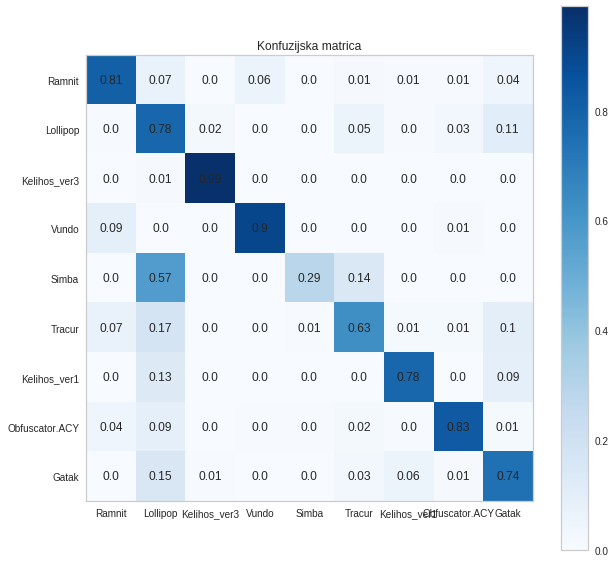

In [10]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model većinom dobro grupira podatke u pripadne kategorije za ovako izabranu grupu značajki nad kojima nije provedena selekcija. Korelacijska matrica je malo 'šarenija' nego što je to bio slučaj za unigram značajke, ali moramo naglasiti da se metadata_bytes skupina značajki sastoji od samo dvije značajke. <br>
Za _Simba_ klasu _malwarea_  rezultat najgori. To je klasa za koju imamo najmanje podataka u train skupu i očito nju metadata_bytes skupina značajki najbolje ne opisuje.

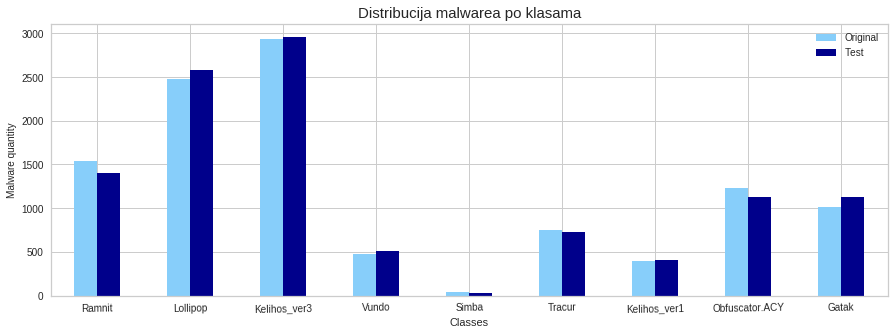

In [11]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo relativno mala odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [12]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? metadata_bytes


<code> kaggle score: 0.47265</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### entropija

In [13]:
entropy_features = features_train_with_filled_NaN_without_id.iloc[:,258:460]
entropy_features_test = features_test_with_filled_NaN_without_id.iloc[:,258:460]

In [14]:
data = entropy_features
data_test = entropy_features_test
labels = malware_classes_train.values.ravel()

In [15]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [16]:
# xgboost with default parameters
basic_model_entropy = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_entropy

Load or make XGBClassifier? make
Ime za XGBClassifier? entropy
[0]	validation_0-merror:0.02508	validation_0-mlogloss:1.09821	validation_1-merror:0.04324	validation_1-mlogloss:1.11638
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.01185	validation_0-mlogloss:0.76130	validation_1-merror:0.02714	validation_1-mlogloss:0.78638
[2]	validation_0-merror:0.00897	validation_0-mlogloss:0.55245	validation_1-merror:0.02622	validation_1-mlogloss:0.58273
[3]	validation_0-merror:0.00771	validation_0-mlogloss:0.41029	validation_1-merror:0.02484	validation_1-mlogloss:0.44491
[4]	validation_0-merror:0.00644	validation_0-mlogloss:0.30693	validation_1-merror:0.02254	validation_1-mlogloss:0.34382
[5]	validation_0-merror:0.00518	validation_0-mlogloss:0.23163	validation_1-merror:0.02208	validation_1-mlogloss:0.27028
[6]	validation_0-merror:0.00449	validation_0-mlogl

[66]	validation_0-merror:0.00000	validation_0-mlogloss:0.00094	validation_1-merror:0.01104	validation_1-mlogloss:0.03655
[67]	validation_0-merror:0.00000	validation_0-mlogloss:0.00093	validation_1-merror:0.01104	validation_1-mlogloss:0.03655
[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00092	validation_1-merror:0.01104	validation_1-mlogloss:0.03651
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00091	validation_1-merror:0.01104	validation_1-mlogloss:0.03648
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00090	validation_1-merror:0.01104	validation_1-mlogloss:0.03648
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00089	validation_1-merror:0.01104	validation_1-mlogloss:0.03655
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00088	validation_1-merror:0.01104	validation_1-mlogloss:0.03653
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00088	validation_1-merror:0.01104	validation_1-mlogloss:0.03645
[74]	validation_0-merror:0.00000

[134]	validation_0-merror:0.00000	validation_0-mlogloss:0.00063	validation_1-merror:0.01104	validation_1-mlogloss:0.03592
[135]	validation_0-merror:0.00000	validation_0-mlogloss:0.00063	validation_1-merror:0.01058	validation_1-mlogloss:0.03590
[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00063	validation_1-merror:0.01058	validation_1-mlogloss:0.03593
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00063	validation_1-merror:0.01058	validation_1-mlogloss:0.03589
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00062	validation_1-merror:0.01058	validation_1-mlogloss:0.03594
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00062	validation_1-merror:0.01104	validation_1-mlogloss:0.03597
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00062	validation_1-merror:0.01104	validation_1-mlogloss:0.03596
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00062	validation_1-merror:0.01058	validation_1-mlogloss:0.03595
[142]	validation_0-merro

[202]	validation_0-merror:0.00000	validation_0-mlogloss:0.00055	validation_1-merror:0.01012	validation_1-mlogloss:0.03546
[203]	validation_0-merror:0.00000	validation_0-mlogloss:0.00055	validation_1-merror:0.01012	validation_1-mlogloss:0.03548
[204]	validation_0-merror:0.00000	validation_0-mlogloss:0.00055	validation_1-merror:0.01012	validation_1-mlogloss:0.03551
[205]	validation_0-merror:0.00000	validation_0-mlogloss:0.00055	validation_1-merror:0.01012	validation_1-mlogloss:0.03548
[206]	validation_0-merror:0.00000	validation_0-mlogloss:0.00055	validation_1-merror:0.01012	validation_1-mlogloss:0.03550
[207]	validation_0-merror:0.00000	validation_0-mlogloss:0.00054	validation_1-merror:0.01012	validation_1-mlogloss:0.03550
[208]	validation_0-merror:0.00000	validation_0-mlogloss:0.00054	validation_1-merror:0.01012	validation_1-mlogloss:0.03551
[209]	validation_0-merror:0.00000	validation_0-mlogloss:0.00054	validation_1-merror:0.01012	validation_1-mlogloss:0.03552
[210]	validation_0-merro

In [153]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.035459
1,accuracy_test,0.989880
2,F1_test,0.989864
3,precision_test,0.989907
4,auc_test_ovr,0.999873
5,auc_test_ovo,0.999743
6,r2_test,0.967100


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

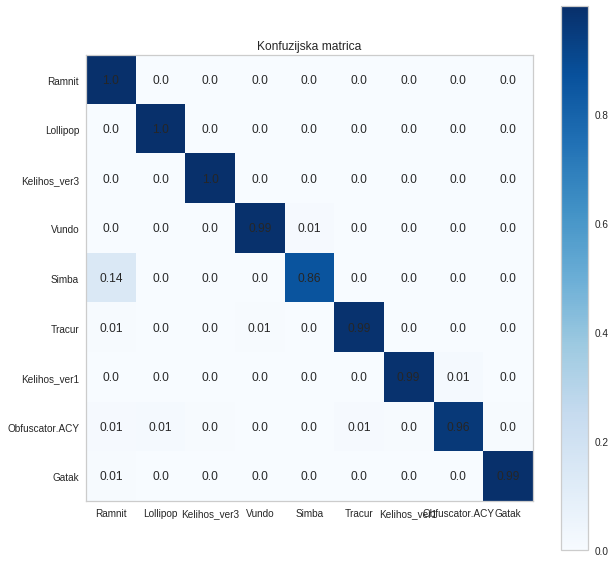

In [17]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

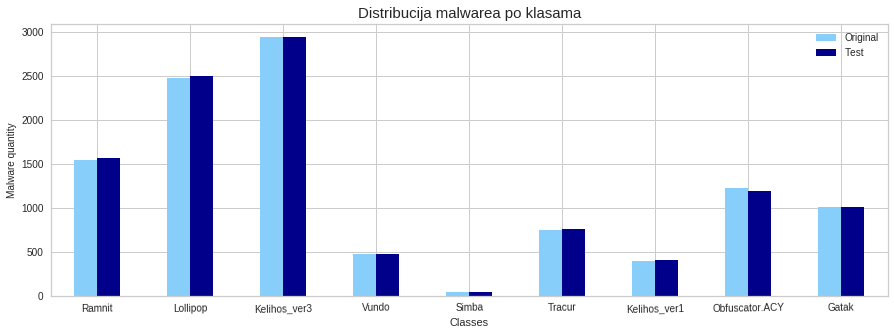

In [18]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo relativno mala odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [141]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? entropy


<code> kaggle score: 0.03434 </code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### slikovna reprezentacija _malwarea_

In [28]:
image_features = features_train_with_filled_NaN_without_id.iloc[:,460:512]
image_features_test = features_test_with_filled_NaN_without_id.iloc[:,460:512]

In [29]:
data = image_features
data_test = image_features_test
labels = malware_classes_train.values.ravel()

In [30]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [31]:
# xgboost with default parameters
basic_model_image = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_image

Load or make XGBClassifier? make
Ime za XGBClassifier? image
[0]	validation_0-merror:0.03313	validation_0-mlogloss:1.11508	validation_1-merror:0.04278	validation_1-mlogloss:1.12591
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.02899	validation_0-mlogloss:0.78977	validation_1-merror:0.04048	validation_1-mlogloss:0.80706
[2]	validation_0-merror:0.02680	validation_0-mlogloss:0.58592	validation_1-merror:0.04094	validation_1-mlogloss:0.61020
[3]	validation_0-merror:0.02381	validation_0-mlogloss:0.44571	validation_1-merror:0.04094	validation_1-mlogloss:0.47638
[4]	validation_0-merror:0.02312	validation_0-mlogloss:0.34457	validation_1-merror:0.03864	validation_1-mlogloss:0.37954
[5]	validation_0-merror:0.01944	validation_0-mlogloss:0.26936	validation_1-merror:0.03634	validation_1-mlogloss:0.30895
[6]	validation_0-merror:0.01680	validation_0-mloglos

[66]	validation_0-merror:0.00000	validation_0-mlogloss:0.00301	validation_1-merror:0.02530	validation_1-mlogloss:0.08480
[67]	validation_0-merror:0.00000	validation_0-mlogloss:0.00296	validation_1-merror:0.02576	validation_1-mlogloss:0.08484
[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00290	validation_1-merror:0.02530	validation_1-mlogloss:0.08474
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00284	validation_1-merror:0.02576	validation_1-mlogloss:0.08496
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00279	validation_1-merror:0.02576	validation_1-mlogloss:0.08491
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00274	validation_1-merror:0.02622	validation_1-mlogloss:0.08496
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00271	validation_1-merror:0.02622	validation_1-mlogloss:0.08506
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00266	validation_1-merror:0.02668	validation_1-mlogloss:0.08533
[74]	validation_0-merror:0.00000

In [32]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.084084
1,accuracy_test,0.974241
2,F1_test,0.974182
3,precision_test,0.974360
4,auc_test_ovr,0.999391
5,auc_test_ovo,0.998763
6,r2_test,0.924847


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

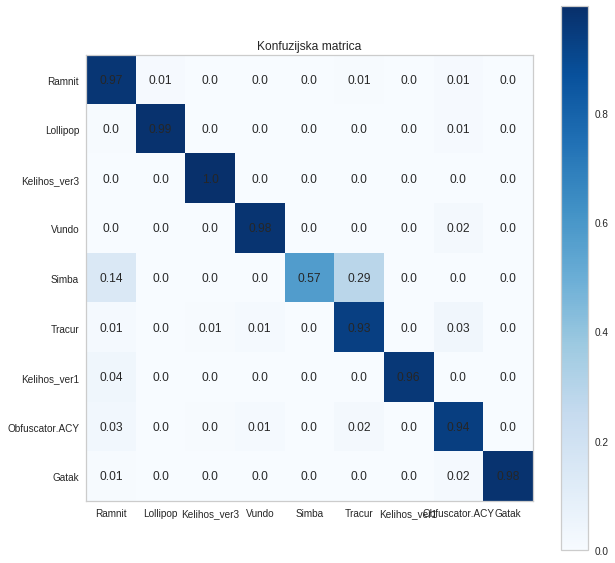

In [33]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju. Rezultati za _Simba_ klasu su očigledno najbolji.

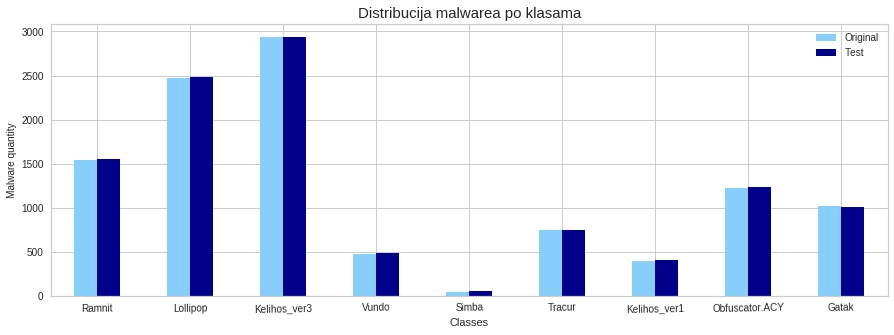

In [34]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

In [156]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? image


<code> kaggle score: 0.07645</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### duljina stringova

In [35]:
string_length_features = features_train_with_filled_NaN_without_id.iloc[:,512:628]
string_length_features_test = features_test_with_filled_NaN_without_id.iloc[:,512:628]


In [36]:
data = string_length_features
data_test = string_length_features_test
labels = malware_classes_train.values.ravel()

In [37]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [38]:
# xgboost with default parameters
basic_model_string_length = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_string_length

Load or make XGBClassifier? make
Ime za XGBClassifier? string_length
[0]	validation_0-merror:0.03647	validation_0-mlogloss:1.13408	validation_1-merror:0.05704	validation_1-mlogloss:1.15095
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.03037	validation_0-mlogloss:0.79970	validation_1-merror:0.05014	validation_1-mlogloss:0.82507
[2]	validation_0-merror:0.02542	validation_0-mlogloss:0.59415	validation_1-merror:0.04600	validation_1-mlogloss:0.62474
[3]	validation_0-merror:0.02347	validation_0-mlogloss:0.45154	validation_1-merror:0.04186	validation_1-mlogloss:0.48679
[4]	validation_0-merror:0.01898	validation_0-mlogloss:0.34961	validation_1-merror:0.03910	validation_1-mlogloss:0.38994
[5]	validation_0-merror:0.01633	validation_0-mlogloss:0.27339	validation_1-merror:0.03542	validation_1-mlogloss:0.31711
[6]	validation_0-merror:0.01380	validation_0

[66]	validation_0-merror:0.00012	validation_0-mlogloss:0.00247	validation_1-merror:0.01932	validation_1-mlogloss:0.06827
Stopping. Best iteration:
[46]	validation_0-merror:0.00012	validation_0-mlogloss:0.00380	validation_1-merror:0.01978	validation_1-mlogloss:0.06774

XGBClassifier je spremljen u: ../dataset/basic_model/model_xgb_string_length.sav


In [39]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.067740
1,accuracy_test,0.980221
2,F1_test,0.980215
3,precision_test,0.980365
4,auc_test_ovr,0.999365
5,auc_test_ovo,0.999097
6,r2_test,0.920460


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

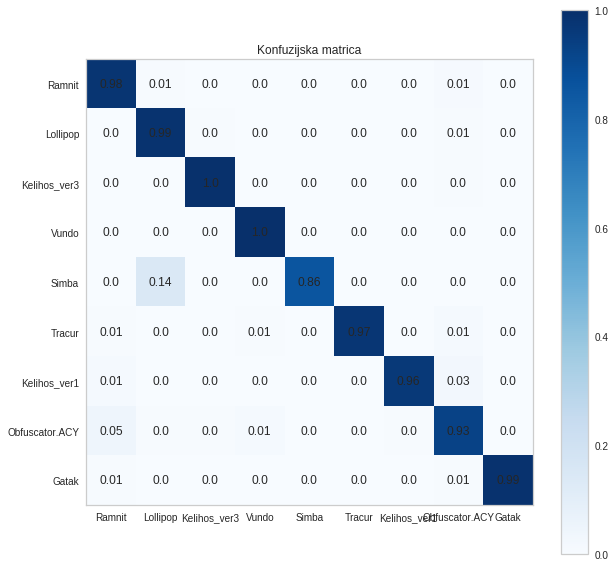

In [43]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

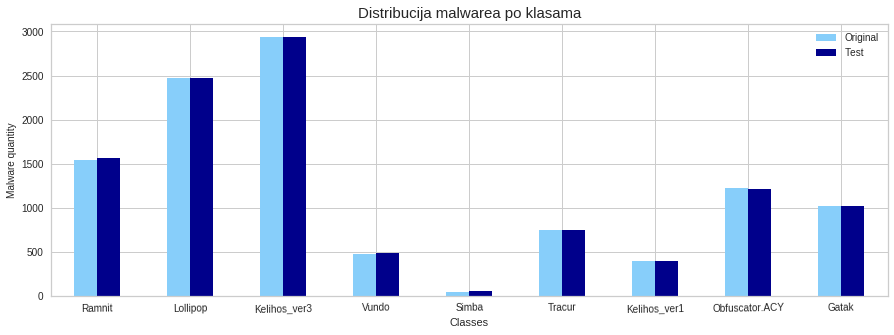

In [44]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo minimalna odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [42]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? string_length


<code> kaggle score: 0.05551</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

## 2.2 Značajke dobivene iz _.asm_ datoteka  <a name = asm> </a>

### metadata

In [46]:
metadata_asm_features = features_train_with_filled_NaN_without_id.iloc[:,628:630]
metadata_asm_features_test = features_test_with_filled_NaN_without_id.iloc[:,628:630]


In [47]:
data = metadata_asm_features
data_test = metadata_asm_features_test
labels = malware_classes_train.values.ravel()

In [48]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [49]:
# xgboost with default parameters
basic_model_metadata_asm = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_metadata_asm

Load or make XGBClassifier? make
Ime za XGBClassifier? metadata_asm
[0]	validation_0-merror:0.14586	validation_0-mlogloss:1.31406	validation_1-merror:0.16329	validation_1-mlogloss:1.33398
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.11596	validation_0-mlogloss:0.99109	validation_1-merror:0.14075	validation_1-mlogloss:1.02478
[2]	validation_0-merror:0.09962	validation_0-mlogloss:0.79681	validation_1-merror:0.12373	validation_1-mlogloss:0.84017
[3]	validation_0-merror:0.08328	validation_0-mlogloss:0.65773	validation_1-merror:0.11407	validation_1-mlogloss:0.70992
[4]	validation_0-merror:0.08191	validation_0-mlogloss:0.55897	validation_1-merror:0.11270	validation_1-mlogloss:0.61817
[5]	validation_0-merror:0.07546	validation_0-mlogloss:0.48825	validation_1-merror:0.10534	validation_1-mlogloss:0.55399
[6]	validation_0-merror:0.07213	validation_0-

[66]	validation_0-merror:0.01392	validation_0-mlogloss:0.06831	validation_1-merror:0.07498	validation_1-mlogloss:0.28178
[67]	validation_0-merror:0.01380	validation_0-mlogloss:0.06759	validation_1-merror:0.07498	validation_1-mlogloss:0.28201
[68]	validation_0-merror:0.01369	validation_0-mlogloss:0.06655	validation_1-merror:0.07452	validation_1-mlogloss:0.28156
[69]	validation_0-merror:0.01346	validation_0-mlogloss:0.06569	validation_1-merror:0.07498	validation_1-mlogloss:0.28159
[70]	validation_0-merror:0.01334	validation_0-mlogloss:0.06495	validation_1-merror:0.07498	validation_1-mlogloss:0.28161
[71]	validation_0-merror:0.01334	validation_0-mlogloss:0.06410	validation_1-merror:0.07498	validation_1-mlogloss:0.28154
[72]	validation_0-merror:0.01311	validation_0-mlogloss:0.06338	validation_1-merror:0.07498	validation_1-mlogloss:0.28162
[73]	validation_0-merror:0.01288	validation_0-mlogloss:0.06257	validation_1-merror:0.07498	validation_1-mlogloss:0.28111
[74]	validation_0-merror:0.01277

In [50]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.280260
1,accuracy_test,0.925943
2,F1_test,0.925658
3,precision_test,0.926391
4,auc_test_ovr,0.991042
5,auc_test_ovo,0.984502
6,r2_test,0.785572


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

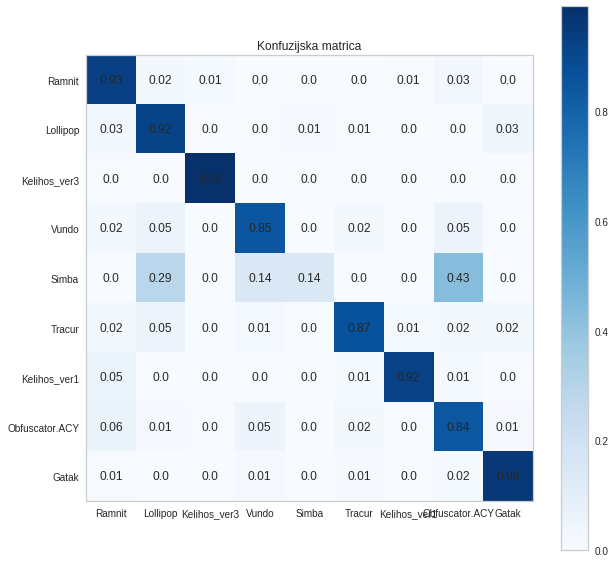

In [72]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model većinom dobro grupira podatke u pripadne kategorije za ovako izabranu grupu značajki nad kojima nije provedena selekcija. Rezultat je odličan pogotovo što se ponovno radi samo o dvije značajke. <br>
Za _Simba_ klasu _malwarea_  rezultat najgori. To je klasa za koju imamo najmanje podataka u train skupu i očito nju metadata skupina značajki (ni iz .bytes ni iz .asm datoteka) najbolje ne opisuje.

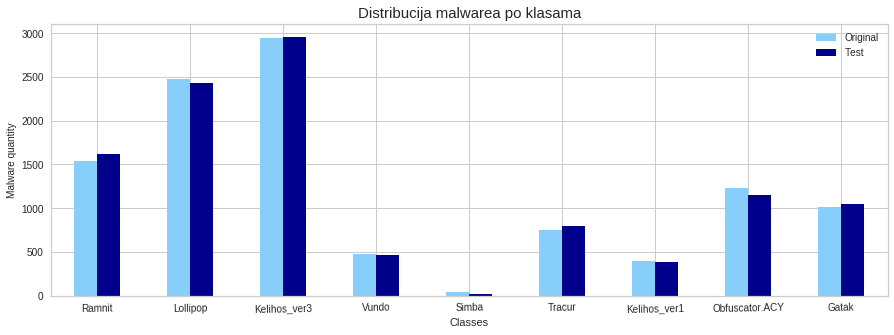

In [51]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo relativno mala odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [157]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? metadata_asm


Opet primjećujemo relativno mala odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

<code> kaggle score: 0.27471</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### simboli

In [52]:
symbols_features = features_train_with_filled_NaN_without_id.iloc[:,630:637]
symbols_features_test = features_test_with_filled_NaN_without_id.iloc[:,630:637]

In [53]:
data = symbols_features
data_test = symbols_features_test
labels = malware_classes_train.values.ravel()

In [54]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [55]:
# xgboost with default parameters
basic_model_symbols = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_symbols

Load or make XGBClassifier? make
Ime za XGBClassifier? symbols
[0]	validation_0-merror:0.06534	validation_0-mlogloss:1.18502	validation_1-merror:0.09154	validation_1-mlogloss:1.21017
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.04820	validation_0-mlogloss:0.85148	validation_1-merror:0.07590	validation_1-mlogloss:0.88788
[2]	validation_0-merror:0.04590	validation_0-mlogloss:0.64576	validation_1-merror:0.07176	validation_1-mlogloss:0.68961
[3]	validation_0-merror:0.03946	validation_0-mlogloss:0.49888	validation_1-merror:0.06624	validation_1-mlogloss:0.54939
[4]	validation_0-merror:0.03463	validation_0-mlogloss:0.39673	validation_1-merror:0.06210	validation_1-mlogloss:0.45261
[5]	validation_0-merror:0.02945	validation_0-mlogloss:0.31915	validation_1-merror:0.05704	validation_1-mlogloss:0.38065
[6]	validation_0-merror:0.02335	validation_0-mlogl

[66]	validation_0-merror:0.00012	validation_0-mlogloss:0.00669	validation_1-merror:0.02944	validation_1-mlogloss:0.11319
[67]	validation_0-merror:0.00012	validation_0-mlogloss:0.00657	validation_1-merror:0.02944	validation_1-mlogloss:0.11321
[68]	validation_0-merror:0.00012	validation_0-mlogloss:0.00641	validation_1-merror:0.02944	validation_1-mlogloss:0.11352
[69]	validation_0-merror:0.00012	validation_0-mlogloss:0.00631	validation_1-merror:0.02944	validation_1-mlogloss:0.11363
[70]	validation_0-merror:0.00012	validation_0-mlogloss:0.00618	validation_1-merror:0.02944	validation_1-mlogloss:0.11373
[71]	validation_0-merror:0.00012	validation_0-mlogloss:0.00602	validation_1-merror:0.02898	validation_1-mlogloss:0.11393
[72]	validation_0-merror:0.00012	validation_0-mlogloss:0.00591	validation_1-merror:0.02898	validation_1-mlogloss:0.11406
[73]	validation_0-merror:0.00012	validation_0-mlogloss:0.00581	validation_1-merror:0.02898	validation_1-mlogloss:0.11384
[74]	validation_0-merror:0.00012

In [56]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.112644
1,accuracy_test,0.970561
2,F1_test,0.970645
3,precision_test,0.971387
4,auc_test_ovr,0.997948
5,auc_test_ovo,0.997230
6,r2_test,0.889883


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

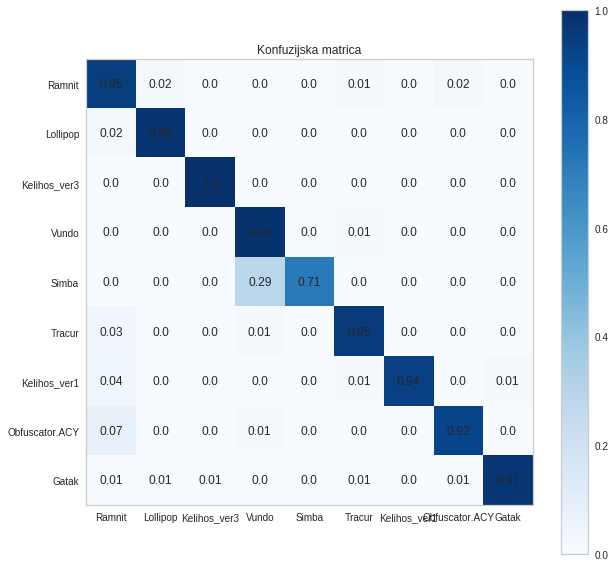

In [57]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju, čak su i za _Simba_ klasu rezultati zadovoljavajući.

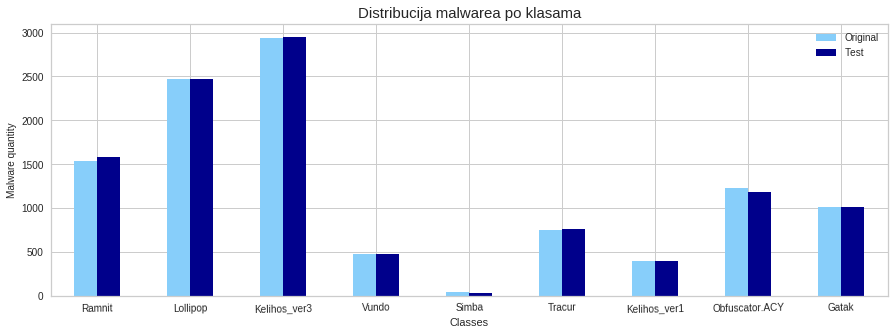

In [58]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo minimalna odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [59]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? symbols


<code> kaggle score: 0.09682</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### opcode

In [60]:
opcode_features = features_train_with_filled_NaN_without_id.iloc[:,637:730]
opcode_features_test = features_test_with_filled_NaN_without_id.iloc[:,637:730]

In [61]:
data = opcode_features
data_test = opcode_features_test
labels = malware_classes_train.values.ravel()

In [62]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [63]:
# xgboost with default parameters
basic_model_opcode = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_opcode

Load or make XGBClassifier? make
Ime za XGBClassifier? opcode
[0]	validation_0-merror:0.01611	validation_0-mlogloss:1.07434	validation_1-merror:0.02760	validation_1-mlogloss:1.08659
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.01231	validation_0-mlogloss:0.74313	validation_1-merror:0.02438	validation_1-mlogloss:0.76236
[2]	validation_0-merror:0.01058	validation_0-mlogloss:0.53626	validation_1-merror:0.02116	validation_1-mlogloss:0.55994
[3]	validation_0-merror:0.00851	validation_0-mlogloss:0.39496	validation_1-merror:0.01978	validation_1-mlogloss:0.42249
[4]	validation_0-merror:0.00771	validation_0-mlogloss:0.29499	validation_1-merror:0.01932	validation_1-mlogloss:0.32543
[5]	validation_0-merror:0.00690	validation_0-mlogloss:0.22229	validation_1-merror:0.01840	validation_1-mlogloss:0.25473
[6]	validation_0-merror:0.00598	validation_0-mloglo

[66]	validation_0-merror:0.00012	validation_0-mlogloss:0.00139	validation_1-merror:0.00920	validation_1-mlogloss:0.04143
[67]	validation_0-merror:0.00012	validation_0-mlogloss:0.00138	validation_1-merror:0.00920	validation_1-mlogloss:0.04142
[68]	validation_0-merror:0.00012	validation_0-mlogloss:0.00137	validation_1-merror:0.00920	validation_1-mlogloss:0.04143
Stopping. Best iteration:
[48]	validation_0-merror:0.00012	validation_0-mlogloss:0.00175	validation_1-merror:0.00966	validation_1-mlogloss:0.04101

XGBClassifier je spremljen u: ../dataset/basic_model/model_xgb_opcode.sav


In [64]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.041014
1,accuracy_test,0.990340
2,F1_test,0.990334
3,precision_test,0.990468
4,auc_test_ovr,0.999681
5,auc_test_ovo,0.999507
6,r2_test,0.956714


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

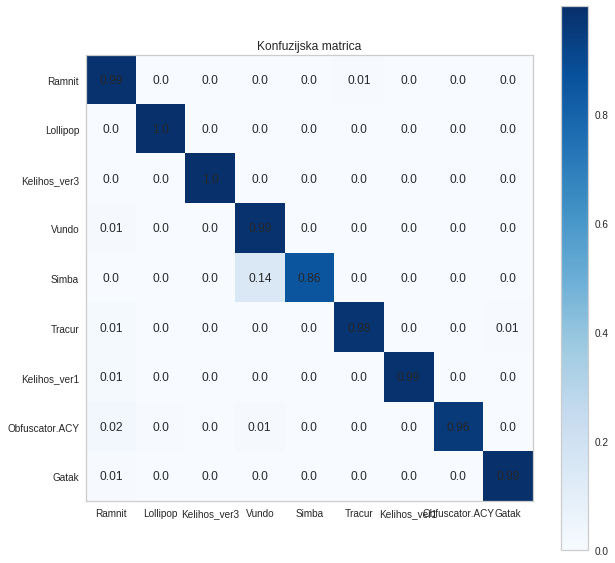

In [65]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju. Čak i za _Simba_ klasu postiguta je visoka točnost.

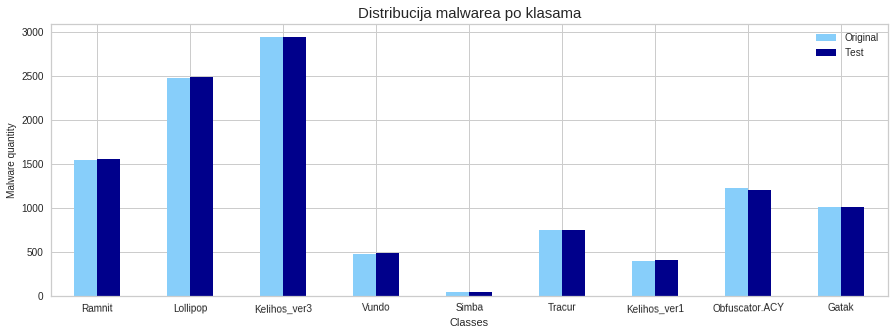

In [66]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo minimalna odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [159]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? opcode


<code> kaggle score: 0.02512</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### registri

In [67]:
reg_features = features_train_with_filled_NaN_without_id.iloc[:,730:756]
reg_features_test = features_test_with_filled_NaN_without_id.iloc[:,730:756]

In [68]:
data = reg_features
data_test = reg_features_test
labels = malware_classes_train.values.ravel()

In [69]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [70]:
# xgboost with default parameters
basic_model_reg = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_reg

Load or make XGBClassifier? make
Ime za XGBClassifier? registers
[0]	validation_0-merror:0.04440	validation_0-mlogloss:1.14949	validation_1-merror:0.06624	validation_1-mlogloss:1.17032
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.02761	validation_0-mlogloss:0.81528	validation_1-merror:0.04922	validation_1-mlogloss:0.84844
[2]	validation_0-merror:0.02634	validation_0-mlogloss:0.60849	validation_1-merror:0.04692	validation_1-mlogloss:0.65028
[3]	validation_0-merror:0.01990	validation_0-mlogloss:0.46344	validation_1-merror:0.04002	validation_1-mlogloss:0.50920
[4]	validation_0-merror:0.01702	validation_0-mlogloss:0.35803	validation_1-merror:0.03496	validation_1-mlogloss:0.40631
[5]	validation_0-merror:0.01564	validation_0-mlogloss:0.28137	validation_1-merror:0.03220	validation_1-mlogloss:0.33261
[6]	validation_0-merror:0.01369	validation_0-mlo

[66]	validation_0-merror:0.00253	validation_0-mlogloss:0.00910	validation_1-merror:0.01794	validation_1-mlogloss:0.06962
[67]	validation_0-merror:0.00253	validation_0-mlogloss:0.00904	validation_1-merror:0.01748	validation_1-mlogloss:0.06989
[68]	validation_0-merror:0.00253	validation_0-mlogloss:0.00899	validation_1-merror:0.01794	validation_1-mlogloss:0.07014
[69]	validation_0-merror:0.00253	validation_0-mlogloss:0.00894	validation_1-merror:0.01748	validation_1-mlogloss:0.07015
[70]	validation_0-merror:0.00253	validation_0-mlogloss:0.00891	validation_1-merror:0.01794	validation_1-mlogloss:0.07033
[71]	validation_0-merror:0.00253	validation_0-mlogloss:0.00888	validation_1-merror:0.01748	validation_1-mlogloss:0.07049
[72]	validation_0-merror:0.00253	validation_0-mlogloss:0.00885	validation_1-merror:0.01748	validation_1-mlogloss:0.07053
[73]	validation_0-merror:0.00253	validation_0-mlogloss:0.00882	validation_1-merror:0.01702	validation_1-mlogloss:0.07054
[74]	validation_0-merror:0.00253

In [71]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.069263
1,accuracy_test,0.982521
2,F1_test,0.982546
3,precision_test,0.982723
4,auc_test_ovr,0.999205
5,auc_test_ovo,0.998902
6,r2_test,0.938523


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

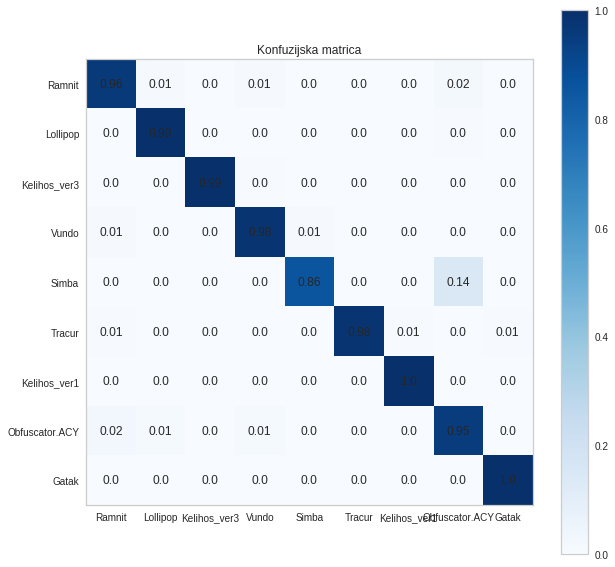

In [72]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

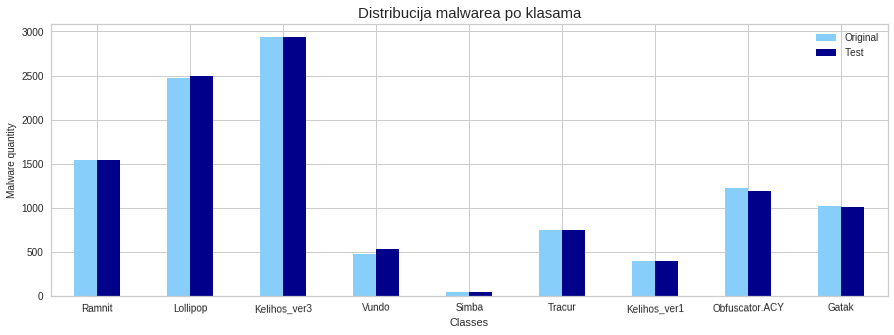

In [73]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju. Čak i za _Simba_ klasu postiguta je visoka točnost.

In [160]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? reg


<code> kaggle score: 0.07756</code>

**Zaključno, ove značajke uzimamo u obzir pri daljnoj selekciji.**

### sekcije

In [74]:
section_features = features_train_with_filled_NaN_without_id.iloc[:,756:780]
section_features_test = features_test_with_filled_NaN_without_id.iloc[:,756:780]

In [75]:
data = section_features
data_test = section_features_test
labels = malware_classes_train.values.ravel()

In [76]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [78]:
# xgboost with default parameters
basic_model_section = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_section

Load or make XGBClassifier? make
Ime za XGBClassifier? section
[0]	validation_0-merror:0.67997	validation_0-mlogloss:2.07482	validation_1-merror:0.72769	validation_1-mlogloss:2.10615
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.65719	validation_0-mlogloss:1.98892	validation_1-merror:0.73827	validation_1-mlogloss:2.04944
[2]	validation_0-merror:0.64374	validation_0-mlogloss:1.92718	validation_1-merror:0.73919	validation_1-mlogloss:2.01169
[3]	validation_0-merror:0.63626	validation_0-mlogloss:1.88156	validation_1-merror:0.74195	validation_1-mlogloss:1.98435
[4]	validation_0-merror:0.62798	validation_0-mlogloss:1.84399	validation_1-merror:0.74333	validation_1-mlogloss:1.96650
[5]	validation_0-merror:0.62706	validation_0-mlogloss:1.81549	validation_1-merror:0.74011	validation_1-mlogloss:1.95184
[6]	validation_0-merror:0.61705	validation_0-mlogl

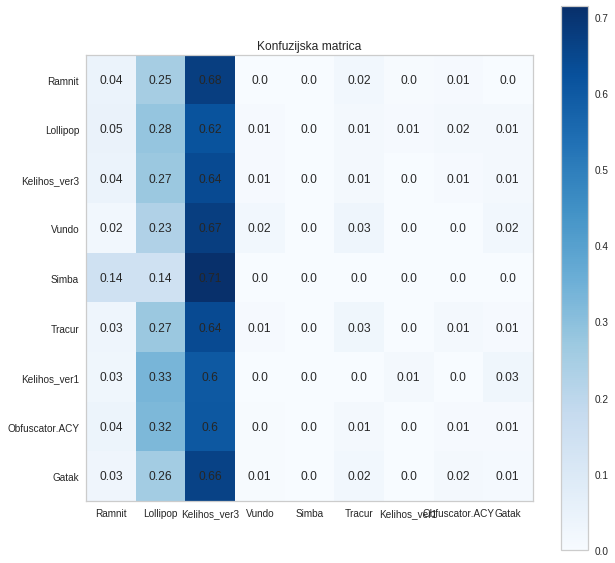

In [104]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz korelacijske matrice vidimo da model treniran na sekcija značajkama većinu _malwarea_ krivo klasificira u _Kelihos_ver3_ klasu. Provjerimo još distribuciju _malwarea_ po klasama.

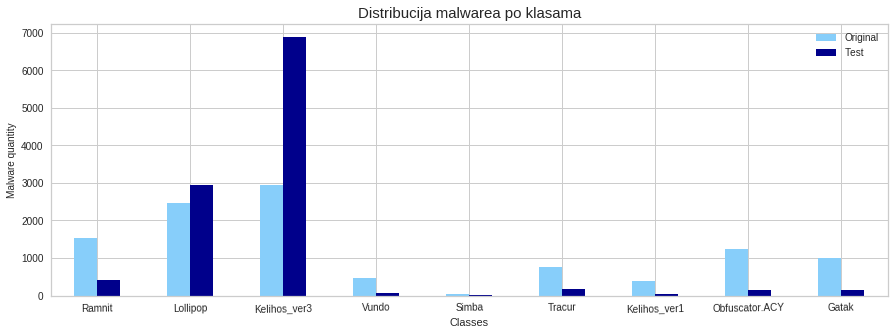

In [105]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Distribucije poprilično odudaraju te je i iz ovog prikaza očito kako je najviše _malwarea_ klasificirano u jednu klasu. Za ovu skupinu ne radimo _submission_ jer nemamo razloga očekivati dobar rezultat.

**Zaključno, ovu grupu značajki eliminiramo već prije početka prave selekcije.**

### data define

In [88]:
dd_features = features_train_with_filled_NaN_without_id.iloc[:,780:804]
dd_features_test = features_test_with_filled_NaN_without_id.iloc[:,780:804]

In [89]:
data = dd_features
data_test = dd_features_test
labels = malware_classes_train.values.ravel()

In [90]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [91]:
# xgboost with default parameters
basic_model_dd = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_dd

Load or make XGBClassifier? make
Ime za XGBClassifier? data_define
[0]	validation_0-merror:0.67859	validation_0-mlogloss:2.07476	validation_1-merror:0.74103	validation_1-mlogloss:2.10738
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.65374	validation_0-mlogloss:1.98646	validation_1-merror:0.74011	validation_1-mlogloss:2.05092
[2]	validation_0-merror:0.63994	validation_0-mlogloss:1.91996	validation_1-merror:0.74195	validation_1-mlogloss:2.01194
[3]	validation_0-merror:0.62786	validation_0-mlogloss:1.86801	validation_1-merror:0.74057	validation_1-mlogloss:1.98607
[4]	validation_0-merror:0.62545	validation_0-mlogloss:1.83020	validation_1-merror:0.73873	validation_1-mlogloss:1.96722
[5]	validation_0-merror:0.61440	validation_0-mlogloss:1.79602	validation_1-merror:0.73873	validation_1-mlogloss:1.95347
[6]	validation_0-merror:0.61199	validation_0-m

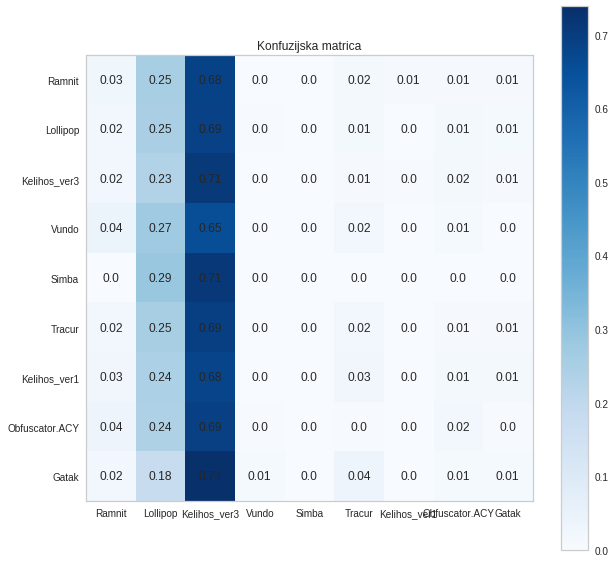

In [111]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

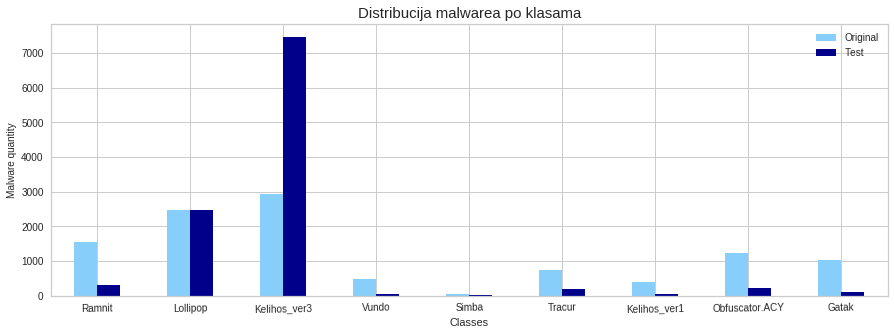

In [112]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Za ovu skupinu značajki vrijede isti zaključci kao za prethodnu (section) skupinu. 

**Zaključno, ovu grupu značajki eliminiramo već prije početka prave selekcije.**

### api

In [15]:
api_features = features_train_with_filled_NaN_without_id.iloc[:,804:1598]
api_features_test = features_test_with_filled_NaN_without_id.iloc[:,804:1598]

In [16]:
data = api_features
data_test = api_features_test
labels = malware_classes_train.values.ravel()

In [17]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [9]:
# xgboost with default parameters
basic_model_api = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_api

Load or make XGBClassifier? make
Ime za XGBClassifier? api
[0]	validation_0-merror:0.03382	validation_0-mlogloss:1.10754	validation_1-merror:0.03956	validation_1-mlogloss:1.11444
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.02473	validation_0-mlogloss:0.77817	validation_1-merror:0.03496	validation_1-mlogloss:0.79259
[2]	validation_0-merror:0.02036	validation_0-mlogloss:0.57108	validation_1-merror:0.03082	validation_1-mlogloss:0.59074
[3]	validation_0-merror:0.01760	validation_0-mlogloss:0.43061	validation_1-merror:0.02806	validation_1-mlogloss:0.45405
[4]	validation_0-merror:0.01576	validation_0-mlogloss:0.33096	validation_1-merror:0.02576	validation_1-mlogloss:0.35624
[5]	validation_0-merror:0.01449	validation_0-mlogloss:0.25717	validation_1-merror:0.02484	validation_1-mlogloss:0.28475
[6]	validation_0-merror:0.01323	validation_0-mlogloss:

[66]	validation_0-merror:0.00621	validation_0-mlogloss:0.02235	validation_1-merror:0.01610	validation_1-mlogloss:0.05741
[67]	validation_0-merror:0.00621	validation_0-mlogloss:0.02232	validation_1-merror:0.01610	validation_1-mlogloss:0.05745
[68]	validation_0-merror:0.00621	validation_0-mlogloss:0.02229	validation_1-merror:0.01610	validation_1-mlogloss:0.05749
[69]	validation_0-merror:0.00621	validation_0-mlogloss:0.02226	validation_1-merror:0.01610	validation_1-mlogloss:0.05758
[70]	validation_0-merror:0.00621	validation_0-mlogloss:0.02224	validation_1-merror:0.01610	validation_1-mlogloss:0.05752
[71]	validation_0-merror:0.00621	validation_0-mlogloss:0.02221	validation_1-merror:0.01610	validation_1-mlogloss:0.05750
[72]	validation_0-merror:0.00621	validation_0-mlogloss:0.02218	validation_1-merror:0.01610	validation_1-mlogloss:0.05749
[73]	validation_0-merror:0.00621	validation_0-mlogloss:0.02215	validation_1-merror:0.01610	validation_1-mlogloss:0.05747
[74]	validation_0-merror:0.00621

In [10]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.056882
1,accuracy_test,0.983901
2,F1_test,0.983949
3,precision_test,0.984854
4,auc_test_ovr,0.999663
5,auc_test_ovo,0.999191
6,r2_test,0.958521


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

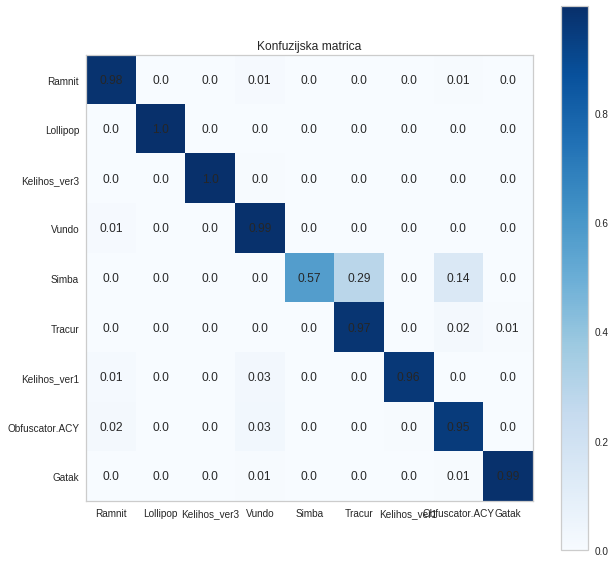

In [11]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju, sa uobičajenom iznimkom - _Simba_ klasa.

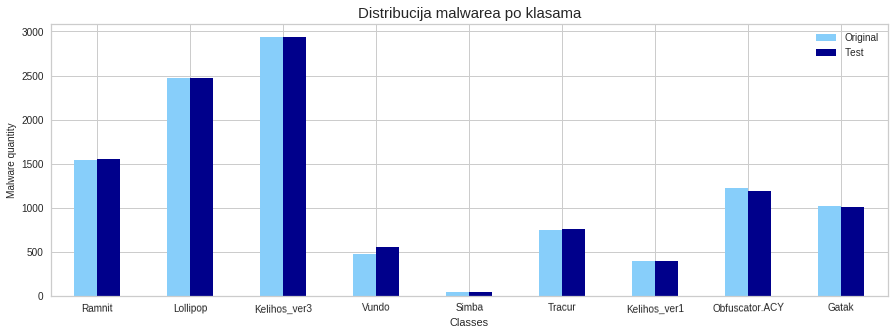

In [12]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo relativno mala odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [163]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? api


<code> kaggle score: 7.52728</code>

Iako se model izrazito dobro ponaša na train skupu, dobili smo neočekivano loš rezultat na Kaggle-u (logloss). <br><br>
Budući da ova skupina sadrži gotovo 800 značajki, pretpostavljamo da je došlo do _overfitanja_ modela. Međutim, trenirajući model na manjim podskupovima ovih značajki, rezultati; kako na train skupa tako i na Kaggle-u, prate prikazani trend - modeli odlično klasificiraju train skup, dok loše prolaze na test skupu. <br>
<br>
Promatrajući strukturu tj. vrijednosti ovih značajki, primjećujemo da je velika većina vrijednosti zapravo jednaka 0, uz iznimke neovisne o klasama, pa kao takve ne nose neku informativnu vrijednost.
<br><br>
Nadalje, svojstvo 'korištenje određenog api-ja' se lako može zaobići korištenjem srodnog api-ja ili internom implementacijom vlastitih metoda, te na taj način i nastaju varijante nekih _malwarea_. Iz toga zaključujemo da su ove značajke pogodnije za **otkrivanje** zlonamjernog softvera nego za njihovu klasifikaciju.
<br>

**Zbog svega navedenog, grupu api značajki također eliminiramo.**

### ključne riječi

In [28]:
key_features = features_train_with_filled_NaN_without_id.iloc[:,1598:1693]
key_features_test = features_test_with_filled_NaN_without_id.iloc[:,1598:1693]

In [29]:
data = key_features
data_test = key_features_test
labels = malware_classes_train.values.ravel()

In [30]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [31]:
# xgboost with default parameters
basic_model_key = XGBClassifier_newer_load_or_make(X_train, y_train, X_test, y_test, n_estimators=400)
model = basic_model_key

Load or make XGBClassifier? make
Ime za XGBClassifier? keywords
[0]	validation_0-merror:0.01783	validation_0-mlogloss:1.08267	validation_1-merror:0.03404	validation_1-mlogloss:1.09971
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.00966	validation_0-mlogloss:0.74369	validation_1-merror:0.01978	validation_1-mlogloss:0.76530
[2]	validation_0-merror:0.00805	validation_0-mlogloss:0.53649	validation_1-merror:0.01794	validation_1-mlogloss:0.56099
[3]	validation_0-merror:0.00736	validation_0-mlogloss:0.39585	validation_1-merror:0.01702	validation_1-mlogloss:0.42226
[4]	validation_0-merror:0.00529	validation_0-mlogloss:0.29455	validation_1-merror:0.01564	validation_1-mlogloss:0.32299
[5]	validation_0-merror:0.00403	validation_0-mlogloss:0.22077	validation_1-merror:0.01610	validation_1-mlogloss:0.25082
[6]	validation_0-merror:0.00322	validation_0-mlog

In [32]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.034459
1,accuracy_test,0.989880
2,F1_test,0.989870
3,precision_test,0.989987
4,auc_test_ovr,0.999880
5,auc_test_ovo,0.999789
6,r2_test,0.964585


Rezultati svih metrika su vrlo dobri te očekujemo slične i na podacima za koje nam nije poznata klasa u koju pripadaju.

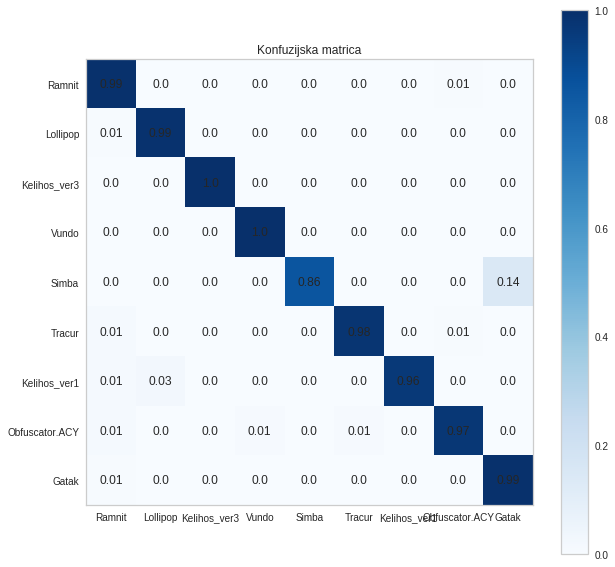

In [33]:
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

Iz konfuzijske matrice vidimo da naš model odlično grupira podatke u klase u koje pripadaju.

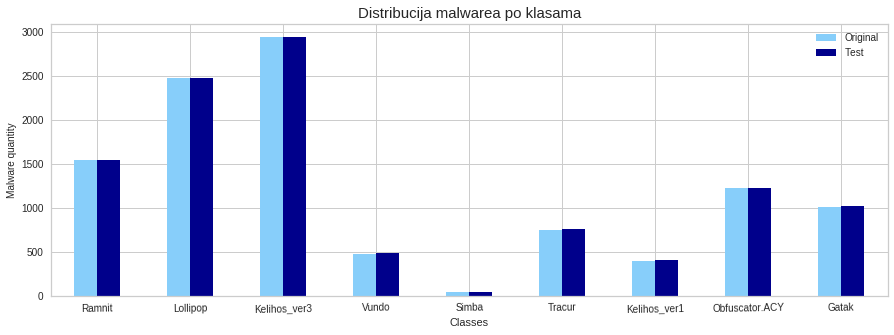

In [34]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(data_test))
compare_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

Opet primjećujemo minimalna odstupanja distribucija <i>malware</i>a po klasama trening skupa (poznato) i test skupa (rezultat predikcije).

In [164]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(data_test))

Ime za submisson file? key


<code> kaggle score: 7.49204</code>

Ponovno smo dobili izrazito loš Kaggle rezultat, suprotno očekivanom.
<br><br>
Razlozi ovakvih rezultata su slični kao u slučaju prethodne grupe, api značajki. Dodatno, značajke iz ove grupe su usko povezane sa section i dd značajkama koje su se također pokazale beznačajnima.
<br><br>
**Zbog svega navedenog, grupu api značajki također eliminiramo.**

<br>

## 2.3 Odabrane podgrupe značajki <a name = podgrupe />

Nakon detaljne analize svake od podgrupa značajki, zaključili smo da su podgrupe nad kojima se treba dalje provoditi selekcija sljedeće:

- iz __.bytes__ datoteka
     - unigram (*one gram* )
     - metapodaci (*metadata* )
     - entropija (*entropy* )
     - slikovna reprezentacija malwarea (*image* )
     - duljina stringova (*string length* )    
- iz __.asm__ datoteka
     - metapodaci (*metadata* )
     - simboli (*symbols* )
     - opcode (*opcode* )
     - registri (*register* )

In [35]:
# groups of features
one_gram_features = features_train_with_filled_NaN_without_id.iloc[:,:256]
metadata_bytes_features = features_train_with_filled_NaN_without_id.iloc[:,256:258]
entropy_features = features_train_with_filled_NaN_without_id.iloc[:,258:460]
image_features = features_train_with_filled_NaN_without_id.iloc[:,460:512]
string_length_features = features_train_with_filled_NaN_without_id.iloc[:,512:628]
metadata_asm_features = features_train_with_filled_NaN_without_id.iloc[:,628:630]
symbols_features = features_train_with_filled_NaN_without_id.iloc[:,630:637]
opcode_features = features_train_with_filled_NaN_without_id.iloc[:,637:730]
reg_features = features_train_with_filled_NaN_without_id.iloc[:,730:756]
section_features = features_train_with_filled_NaN_without_id.iloc[:,756:780]
dd_features = features_train_with_filled_NaN_without_id.iloc[:,780:804]
api_features = features_train_with_filled_NaN_without_id.iloc[:,804:1598]
key_features = features_train_with_filled_NaN_without_id.iloc[:,1598:1693]

one_gram_features_test = features_test_with_filled_NaN_without_id.iloc[:,:256]
metadata_bytes_features_test = features_test_with_filled_NaN_without_id.iloc[:,256:258]
entropy_features_test = features_test_with_filled_NaN_without_id.iloc[:,258:460]
image_features_test = features_test_with_filled_NaN_without_id.iloc[:,460:512]
string_length_features_test = features_test_with_filled_NaN_without_id.iloc[:,512:628]
metadata_asm_features_test = features_test_with_filled_NaN_without_id.iloc[:,628:630]
symbols_features_test = features_test_with_filled_NaN_without_id.iloc[:,630:637]
opcode_features_test = features_test_with_filled_NaN_without_id.iloc[:,637:730]
reg_features_test = features_test_with_filled_NaN_without_id.iloc[:,730:756]
section_features_test = features_test_with_filled_NaN_without_id.iloc[:,756:780]
dd_features_test = features_test_with_filled_NaN_without_id.iloc[:,780:804]
api_features_test = features_test_with_filled_NaN_without_id.iloc[:,804:1598]
key_features_test = features_test_with_filled_NaN_without_id.iloc[:,1598:1693]

selected_train = pd.concat([one_gram_features, metadata_bytes_features, entropy_features, image_features, 
                               string_length_features, metadata_asm_features ,symbols_features, opcode_features, reg_features], axis=1)
selected_test = pd.concat([one_gram_features_test, metadata_bytes_features_test, entropy_features_test, image_features_test, 
                               string_length_features_test, metadata_asm_features_test ,symbols_features_test, opcode_features_test, reg_features_test], axis=1)

In [36]:
#selected_train.to_csv('removed_overfitting_features_train_filled_NaN.csv', index=False)
#selected_test.to_csv('removed_overfitting_features_test_filled_NaN.csv', index=False)

In [38]:
#load selected features
selected_train = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/selected%20features/removed%20api%2Ckeys%2Cdd%2Csection/removed_overfitting_features_train_filled_NaN.csv")
selected_test = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/selected%20features/removed%20api%2Ckeys%2Cdd%2Csection/removed_overfitting_features_test_filled_NaN.csv")

In [39]:
selected_train.head()

,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,byte_1G_08,byte_1G_09,...,asm_regs_cx,asm_regs_dh,asm_regs_dl,asm_regs_dx,asm_regs_eax,asm_regs_ebp,asm_regs_ebx,asm_regs_ecx,asm_regs_edi,asm_regs_esp
0,21091,1213,726,817,1257,625,550,523,1078,473,...,0,0,0,0,137,43,19,66,15,81
1,40030,1980,1226,1193,1971,1096,961,755,2406,550,...,33,4,15,20,9839,6382,2511,5024,3972,713
2,19419,955,693,656,832,463,370,510,836,449,...,4,0,15,0,2111,446,444,1378,562,730
3,79568,6445,3143,2517,4982,1824,2125,2964,8301,1530,...,94,8,232,46,41449,28751,11489,15737,16619,2832
4,25791,1202,569,750,948,456,405,517,754,494,...,2,0,5,0,2637,930,930,1561,1240,844


<br>

# 3. Odabir značajki uz pomoć prediktivnog modela <a name = odabir> </a>

Kroz predselekciju značajki broj značajki je prepolovljen te je pokazano da sve one nose bitnu informativnu vrijednost. <br>
Finalan skup značajki na kojima ćemo trenirati model odabiremo koristeći proceduru za rekurzivnu eliminaciju značajki uz klasifikator slučajnih šuma (implementiran u _sklearn.ensemble.RandomForestClassifier_ ). 
<br><br>
Uz navedeno, pomoću unakrsne validacije saznajemo koliki optimalan udio značajki u finalnoj selekciji (funkcija <code>sklearn.feature_selection.RFECV</code> implementirana u _sklearn.cross_validation.StratifiedKFold_ ). Za parametar <code>k</code> uzimamo vrijednost $5$. Budući da baratamo s nebalansiranim podacima u train skupu, funkcijom <code>StratifiedKFold()</code> osiguravamo očuvanje distribucija klasa u trian i test skupovima za svako vrednovanje određenog modela.
<br>
Parametar <code>scoring</code> koji opisuje sustav vrednovanja modela smo uzeli najbolji od dolje navedenih.
- accuracy
- roc_auc_ovo
- f1_micro

Najbolje rezultate smo dobili korištenjem značajki dobivenih uz <code>scoring='roc_auc_ovo'</code>  (*area under curve*) koji vrednuje modele s obzirom na površinu ispod pripadne ROC krivulje. 

In [51]:
data = selected_train
data_test = selected_test
labels = malware_classes_train.values.ravel()

Computes the average AUC of all possible pairwise combinations of classes [5]. **Insensitive to class imbalance when average == 'macro'.**

In [54]:
rfecv_rf_ovo = RFECV(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=True), 
                 step=1, 
                 cv=StratifiedKFold(n_splits=5),
                 scoring='roc_auc_ovo')

rfecv_rf_ovo.fit(data, labels)

print("Optimalan broj značajki dobivenih metodom slučajnih šuma : %d" % rfecv_rf_ovo.n_features_)

# plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Broj odabranih značajki")
plt.ylabel("Cross validation točnost (broj točnih klasificiranja)")
plt.plot(range(1, len(rfecv_rf_ovo.grid_scores_) + 1), rfecv_rf_ovo.grid_scores_)
plt.show()

# save
#filename = 'data/SAMORFECV_rfecv_rf_OVO_cv5_nestim200.sav'
#pickle.dump(rfecv_rf_ovo, open(filename, 'wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

KeyboardInterrupt: 

In [ ]:
# save selected features and their scores
[names_and_importance_scores_sorted_ovo, selected_features_rfc_train_ovo, selected_features_rfc_test_ovo] = rfecv_save(rfecv_rf_ovo, 'SAMORFECV_rfecv_rf_OVO_cv5_nestim200', data.copy() , features_train, data_test.copy())

Zbog velike vremenski složenosti algoritma, model učitavamo iz datoteke u koju smo je prethodno spremili.

In [63]:
filename = '../dataset/selected features/ROC_AUC/SAMORFECV_rfecv_rf_OVO_cv5_nestim200.sav'
rfecv_rf_ovo = pickle.load(open(filename, 'rb'))
#warning zbog različitih verzija 

/home/margarita/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/margarita/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/margarita/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RFECV from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [84]:
# RFECV
# load features from train and test dataset given using rfecv
selected_features_rfc_train_ovo = pd.read_csv("../dataset/selected features/ROC_AUC/samo rfecv/features_train_SAMORFECV_rfecv_rf_OVO_cv5_nestim200.csv")
selected_features_rfc_test_ovo = pd.read_csv("../dataset/selected features/ROC_AUC/samo rfecv/features_test_SAMORFECV_rfecv_rf_OVO_cv5_nestim200.csv")
# load table with feature names and their scores, sorted
feature_importances = pd.read_csv("../dataset/selected features/ROC_AUC/samo rfecv/SAMORFECV_rfecv_rf_OVO_cv5_nestim200_feature_selected_with_names_and_importance_scores_sorted.csv")
print('Broj odabranih značajki: ', len(feature_importances["feature_name"]))

Broj odabranih značajki:  415


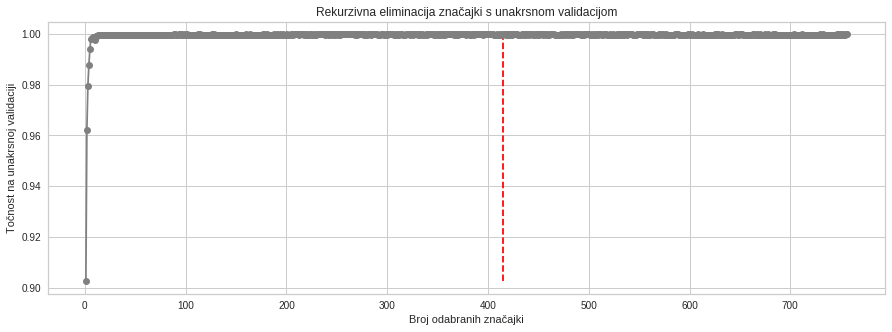

In [60]:
# recursive elimination of features 
rfecv_plot(rfecv_rf_ovo)

Kao optimalan broj značajki dobivamo $415$ značajki. Međutim, iz grafa je vidljivo da je i za puno manji broj značajki točnost na unakrsnoj validaciji zanemarivo lošija. 

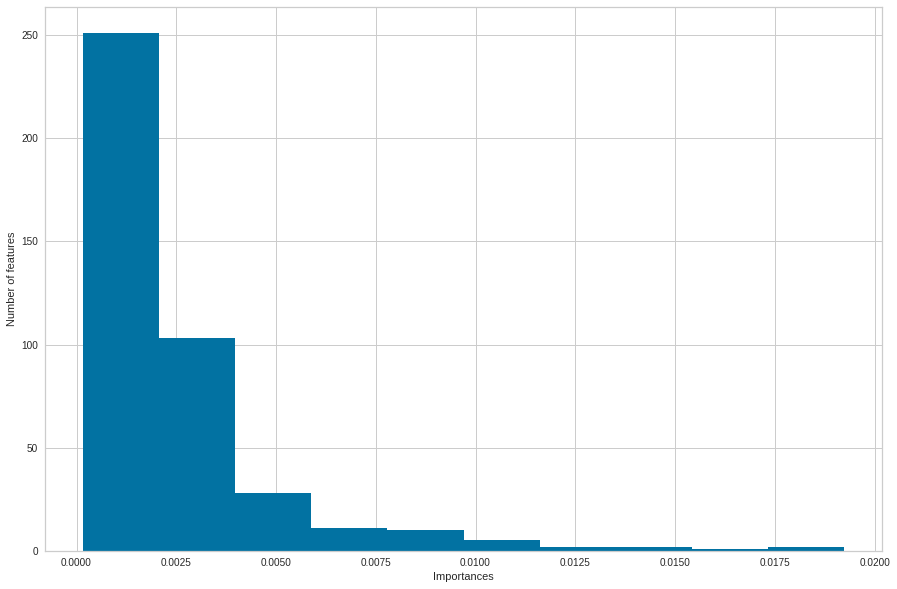

In [64]:
# plot histogram representing distribution of features by feature importance
rfecv_hist(rfecv_rf_ovo)

Vidimo da veliki broj ovako odabranih značajki ipak spada u skup s najnižom značajnosti. Ovo shvaćamo kao još jedan znak da je moguće dodatno smanjiti broj značajki uz i dalje visoku točnost klasifikacije. <br><br>
Točan broj najboljih značajki stoga odabiremo jednostavnom _pohlepnom_ metodom; trenirali smo model koristeći od $50$ do $415$ najboljih značajki s korakom $4$, te uspoređivali rezultate. <br><br>
**Napokon, najbolji rezultat smo dobili uz prvih $208$ značajki.**

In [81]:
number_of_features_to_use = 208
final_features_train = selected_features_rfc_train_ovo[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
final_features_train = selected_features_rfc_test_ovo[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]


final_features_train

,ent_q_diff_diffs_1_min,ent_q_diff_diffs_2_median,ent_q_diff_diffs_2_min,byte_1G_a2,byte_1G_a7,string_len_counts_98,ent_p_19,byte_offset,string_len_counts_150_250,byte_1G_b1,...,ent_p_diffs_2,byte_Img1_0,byte_1G_4a,ent_p_diffs_3,string_len_counts_16,ent_q_diff_diffs_0_mean,byte_1G_96,ent_q_diff_block_3_3,asm_opcodes_mov,ent_q_diff_diffs_11
0,-0.027493,-0.033848,-0.040906,945,907,0,3.957769,4198400,0,1009,...,0.002822,0.735071,1050,0.002967,18,1.127318,819,0.003986,671,0.058944
1,-0.018756,-0.023014,-0.028019,838,838,0,3.989537,4198400,0,803,...,0.005397,0.659010,996,0.001929,17,1.141656,1083,0.001494,696,0.083492
2,-0.023754,-0.029536,-0.035663,1022,868,0,3.985641,4198400,0,898,...,0.002448,0.699353,1142,0.002448,39,0.606887,959,0.002590,621,0.070192
3,-0.011677,-0.015910,-0.019259,564,598,0,3.994521,4198400,0,556,...,0.001337,0.662663,596,0.001337,35,2.099016,580,0.000000,777,0.082198
4,-0.033611,-0.035746,-0.044177,3076,3015,0,3.951041,4198400,0,3192,...,0.003370,0.432261,3149,0.003370,6,0.036530,3131,0.000000,190,0.167950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10868,-0.044909,-0.055508,-0.066761,3167,3345,0,3.926813,4198400,0,3122,...,0.004500,0.552718,3176,0.004500,3,0.019577,3189,0.000000,181,0.126098
10869,-0.020922,-0.026178,-0.031433,55,3,0,-0.001684,4198400,0,2,...,0.002101,0.990168,93,0.002101,3,0.038321,24,0.000686,71,0.000583
10870,-0.033864,-0.042312,-0.050758,3115,3286,0,3.994656,4198400,0,3371,...,0.003377,0.410586,3262,0.003377,10,3.965620,3298,0.003416,60,0.174082
10871,3.756441,3.771266,3.688179,529,437,1,3.818576,4198400,2,448,...,0.141154,0.008746,399,0.248968,5,3.631881,470,0.000000,442,0.489943


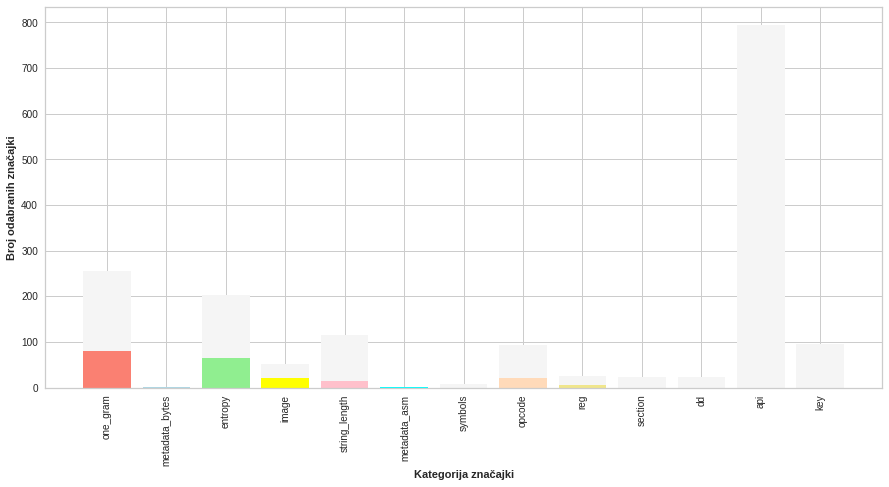

In [83]:
# plot distribution over feature groups
features_type_quantity(list(feature_importances["feature_name"].values[:number_of_features_to_use]), features_train)

Gornji prikaz opisuje distribuciju finalno odabranih značajki po grupama. Grupe s najvećim internim omjerom izabranih i svih značajki su _entropy, image, opcode te one_gram_. Upravo modeli trenirani na tim grupama značajki su u predselekciji davali najbolje rezultate.        